In [1]:
import pandas as pd

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

2023-11-21 14:03:26.848130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 14:03:27.416360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Setup and Configuration

In [8]:
# Alabama data
file = "./ML_Training_01.csv"

# read data into a Pandas dataframe
df = pd.read_csv(file)

# ignore first few columns, which are FIPs codes, not needed for ML
df = df.iloc[:, 3:] 

df = df.rename( columns={"OrnlType":"BuildingType"} )
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
0,-86.452369,32.454446,2168.997509,62660.0,24170.0,2.409557,77,10.0,602.0,3.0,6.0,119.0,residential,Education
1,-86.451701,32.454445,3918.400075,62660.0,24170.0,2.409557,94,10.0,602.0,3.0,6.0,119.0,residential,Education
2,-86.451652,32.453549,501.138397,62660.0,24170.0,2.409557,47,10.0,602.0,3.0,6.0,119.0,residential,Education
3,-86.456148,32.454743,487.162570,62660.0,24170.0,2.409557,56,10.0,602.0,3.0,6.0,119.0,residential,Education
4,-86.451483,32.454827,16.444244,62660.0,24170.0,2.409557,83,10.0,602.0,3.0,6.0,119.0,residential,Education


In [13]:
# classify a building as "Residential", "Commercial", or "Other"
df.loc[df["BuildingType"] == "Industrial", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Assembly", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Education", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Government", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Agriculture", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Utility and Misc", "BuildingType"] = 'Other'

# building type distributions
x = df['BuildingType'].value_counts()
print()
print( x )
print()
print( x[0]/df['BuildingType'].value_counts() )
print()


Residential    2060502
Commercial      136922
Other           110849
Name: BuildingType, dtype: int64

Residential     1.000000
Commercial     15.048728
Other          18.588368
Name: BuildingType, dtype: float64



In [14]:
from sklearn import preprocessing

df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])

df = df.dropna()

nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] ) # ornl type
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) # nearest road type
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

/tmp/ipykernel_201838/1358776107.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
/tmp/ipykernel_201838/1358776107.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )


In [15]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
949447,-0.188732,0.294984,-0.167009,0.374683,2.322184,-0.024318,0.789931,-0.507780,2.387892,1.377641,2.080504,2.245948,4,2
2018575,-0.091686,0.210615,-0.322905,2.668814,-0.044329,1.872737,0.661468,0.136188,0.103582,-1.105771,0.247364,0.414567,4,2
1644613,-1.647388,-1.832330,-0.299032,-0.302436,0.989616,0.370678,-1.051383,2.988046,0.781750,1.116229,0.577660,1.041752,4,2
1596416,-1.691669,-1.987812,-0.373215,-0.302436,0.989616,0.370678,-0.023673,2.988046,0.781750,1.116229,0.577660,1.041752,4,2
1885326,-0.274081,1.127910,-0.101051,0.166470,-0.426574,0.732498,0.789931,-0.691770,-0.417104,-0.975065,-0.644434,-0.181742,4,2


In [16]:
nClasses = len(df['BuildingType'].unique())
print("Number of classes:", nClasses)

Number of classes: 3


In [17]:
buildingTypes = np.array(df['BuildingType'])
df = df.drop( columns=['BuildingType'] )

### Bayesian Neural Network

In [21]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  
                            tf.cast(df.shape[0], dtype=tf.float32))

tfd = tfp.distributions

# Define a logistic regression model as a Bernoulli distribution
# parameterized by logits from a single linear layer. We use the Flipout
# Monte Carlo estimator for the layer: this enables lower variance
# stochastic gradients than naive reparameterization.
input_layer = tf.keras.layers.Input(shape=df.shape[1])

#dense_layer = tfp.layers.DenseFlipout(
#    units=1,
#    activation='sigmoid',
#    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
#    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
#    kernel_divergence_fn=kl_divergence_function)(input_layer)

layer1 = tfp.layers.DenseFlipout(
    units=26,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(input_layer)

layer2 = tfp.layers.DenseFlipout(
    units=13,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer1)

layer3 = tfp.layers.DenseFlipout(
    units=8,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer2)

layer4 = tfp.layers.DenseFlipout(
    units=4,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer3)

out = tfp.layers.DenseFlipout(
    units=3,
    activation='softmax',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer4)

# Model compilation
#bnn = tf.keras.Model(inputs=input_layer, outputs=dense_layer)
bnn = tf.keras.Model(inputs=input_layer, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  
# We use the binary_crossentropy loss since this toy example contains
# two labels. The Keras API will then automatically add the
# Kullback-Leibler divergence (contained on the individual layers of
# the model), to the cross entropy loss, effectively
# calcuating the (negated) Evidence Lower Bound Loss (ELBO)
bnn.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_flipout (DenseFlipout  (None, 26)               728       
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 13)               702       
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 8)                224       
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 4)                72        
 ut)                                                         

In [24]:
bnn.load_weights("bnn.h5")

### Analysis

In [25]:
import numpy as np

def getPredictions( model, data, T ):

    n = data.shape[0]
    preds = np.zeros( shape=(n,nClasses,T) )
    
    for t in range(T):
        if ( t == 10 ): print("Iteration 10...")
        if ( t == 30 ): print("Iteration 30...")
        if ( t == 50 ): print("Iteration 50...")
        if ( t == 70 ): print("Iteration 70...")
        if ( t == 90 ): print("Iteration 90...")
        preds[:,:,t] = model(data)
        
    return preds

In [26]:
T = 100
preds = getPredictions( bnn, df.values, T )
preds.shape

Iteration 10...
Iteration 30...
Iteration 50...
Iteration 70...
Iteration 90...


(1140006, 3, 100)

In [27]:
def getUncertainty( preds, T ):
    
    n = preds.shape[0]
    errors = np.zeros( shape=(n, nClasses) )
    means = np.zeros( shape=(n, nClasses) )
    
    for ix in range(n):
        for j in range(nClasses):
        
            means[ix,j] = np.mean( preds[ix,j,:] )
            #errors[ix,j] = (1./T) * np.sum( (preds[ix,j,:] - means[ix,j])**2 )
            errors[ix,j] = 2. * np.std(preds[ix,j,:])
            
    return means, errors

In [28]:
means, errors = getUncertainty( preds, T )

In [29]:
bnnPreds = []
for ix in range(len(means)):
    ix = np.where( means[ix] == np.max(means[ix]) )
    bnnPreds.append( ix[0][0] )

bnnPreds = np.array(bnnPreds)

In [30]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix( buildingTypes, bnnPreds, normalize='true' )

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


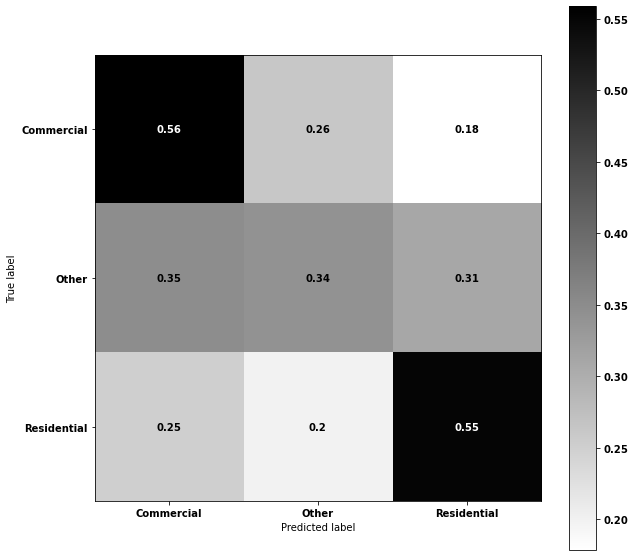

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

print( "Balanced Accuracy:", np.round( balanced_accuracy_score(buildingTypes, bnnPreds), 4 ))
print( "Micro F1:", np.round( f1_score(buildingTypes, bnnPreds, average='micro'), 4 ))

Balanced Accuracy: 0.4834
Micro F1: 0.5432


#### Hypothesis Testing

In [36]:
from scipy import stats

def tTest( sample1, sample2 ):
    
    t_stat, p_value = stats.ttest_ind( sample1, sample2 )

    # True = significant difference, False = not significant
    alpha = 0.05
    if p_value < alpha:
        return True
    else:
        return False

In [52]:
ixs = []
bnnPreds = []
predsMade = 0
n = preds.shape[0]

noPrediction = []

for i in range(n):
    
    ix = np.argsort( -means[i,:] ) # sort in descending order
    
    sample1 = preds[i, ix[0], :]
    sample2 = preds[i, ix[1], :]
    significant = tTest( sample1, sample2 )
    
    mx = np.max( means[i,:] )
    ix = np.where( means[i,:] == mx )
    
    if ( significant and (mx >= 0.65) ):
        predsMade += 1
        bnnPreds.append(ix[0][0])
        ixs.append(i)
    else:
        noPrediction.append(i)
        
print("Total buildins:", n)
print("Predications made:", predsMade)
print("% of buildings with prediction:", np.round( (predsMade/n)*100., 2) )

Total buildins: 1140006
Predications made: 409507
% of buildings with prediction: 35.92


In [53]:
cm = confusion_matrix( buildingTypes[ixs], bnnPreds, normalize='true' )

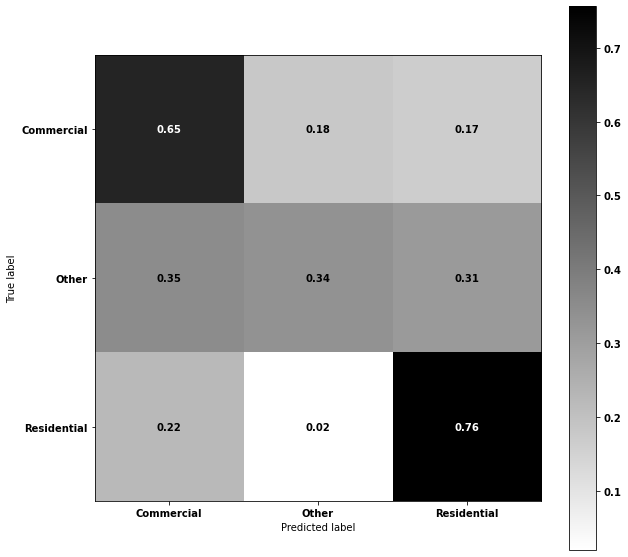

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [55]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(buildingTypes[ixs], bnnPreds), 4 ))
print( "Micro F1:", np.round( f1_score(buildingTypes[ixs], bnnPreds, average='micro'), 4 ))

Balanced Accuracy: 0.5817
Micro F1: 0.7346


Text(0, 0.5, 'Probability')

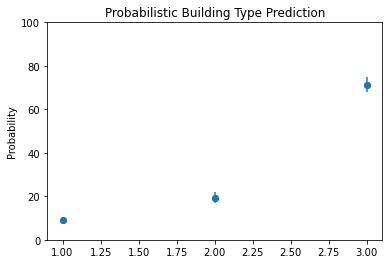

In [71]:
plt.scatter( [1,2,3], means[2,:]*100 ) 
plt.errorbar( [1,2,3], means[2,:]*100, yerr=errors[2,:]*100, fmt="o")
plt.ylim(0,100)
plt.title('Probabilistic Building Type Prediction')
plt.ylabel('Probability')

2 [0.05852261 0.10924447 0.83223292] [0.00330635 0.00526524 0.00806944]


Text(0, 0.5, 'Probability')

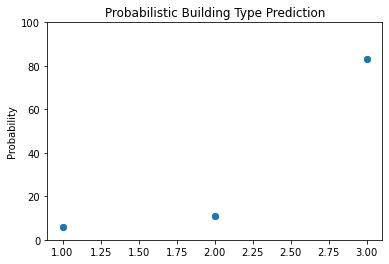

In [88]:
for i in range( means.shape[0] ):

    mx = np.max( means[i,:] )
    ex = np.max( errors[i,:] )
    if ( mx > 0.7 and yTest.iloc[i] == 2  and ex < 0.1 ):
        print( yTest.iloc[i], means[i,:], errors[i,:] )
        x = [1,2,3]
        y = means[i,:]*100.
        e = errors[i,:]*100.
        break 
        
plt.scatter( x, y ) 
plt.errorbar( x, y, yerr=e, fmt="o")
plt.ylim(0,100)
plt.title('Probabilistic Building Type Prediction')
plt.ylabel('Probability')